# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [3]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package

from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

### **Loading the catalog**

In [4]:
# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name='appointment_attendance')

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [5]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,JUL2021,Attended,GP,Face-to-Face,1 Day,1955
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,JUL2021,Attended,GP,Face-to-Face,15 to 21 Days,336
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,JUL2021,Attended,GP,Face-to-Face,2 to 7 Days,3794
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,JUL2021,Attended,GP,Face-to-Face,22 to 28 Days,152
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,JUL2021,Attended,GP,Face-to-Face,8 to 14 Days,1275


#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [6]:
# Function to convert months to FY-YEARS
def convert_to_fy(timestamp):
    if timestamp.month >=4:
        return timestamp.year
    else:
        return timestamp.year - 1 

In [7]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

combined_df_copy['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH'], format="%b%Y").dt.to_period('M')
    
combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021']
combined_df_copy['APPOINTMENT_MONTH'].unique()

<PeriodArray>
['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01',
 '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
 '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
 '2023-11', '2023-12']
Length: 30, dtype: period[M]

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [8]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
attended_df['FY_YEAR'] = attended_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments attended
attended_df_mean = attended_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
attended_df_mean['COUNT_OF_APPOINTMENTS'] = attended_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
attended_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021               448055.1
                                                   FY2022               459362.6
                                                   FY2023               474454.8
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               412063.9
                                                   FY2022               413585.7

2023 ka average match islie nahe ho raha hai kyunki divide 12 se nahe balki 5 se ho raha hai kyunki data me august/23 tak ka data ha FY23 k lie

In [9]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
do_not_attend_df['FY_YEAR'] = do_not_attend_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
dna_df_mean = do_not_attend_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
dna_df_mean['COUNT_OF_APPOINTMENTS'] = dna_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
dna_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                15430.6
                                                   FY2022                16003.8
                                                   FY2023                16542.2
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                17071.9
                                                   FY2022                19536.8

In [10]:
# Dataframe for appointments DNA
unknown_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Unknown'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
unknown_df['FY_YEAR'] = unknown_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
unknown_df_mean = unknown_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = unknown_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
unknown_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                20261.0
                                                   FY2022                16197.5
                                                   FY2023                31100.6
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                14881.9
                                                   FY2022                16174.3

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [11]:
# Convert the 'count_column' to numeric
attended_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(attended_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_attended_2021 = attended_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_attended_2022 = attended_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_attended_2023_april_august = attended_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_attended = attended_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended_2021.item()} is the National average for attended appointments(FY-2021)')
print(f'{National_average_attended_2022.item()} is the National average for attended appointments(FY-2022)')
print(f'{National_average_attended_2023_april_august.item()} is the National average for attended appointments(FY-2023, april-august)')

SNEE_average_attended

590868.95 is the National average for attended appointments(FY-2021)
608099.22 is the National average for attended appointments(FY-2022)
617222.87 is the National average for attended appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,457145.4
FY2022,465021.9
FY2023,469745.9


#### **2. Not attended (DNA) Appointments**

In [12]:
# Convert the 'count_column' to numeric
dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_dna_2021 = dna_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_dna_2022 = dna_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_dna_2023_april_august = dna_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_DNA = dna_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

28924.54 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
32014.04 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,17453.4
FY2022,17822.6
FY2023,16704.0


#### **3. Unknown Appointments**

In [13]:
# Convert the 'count_column' to numeric
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(unknown_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_unknown_2021 = unknown_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_unknown_2022 = unknown_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_unknown_2023_april_august = unknown_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_unknown = unknown_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_unknown_2021.item()} is the National average for Unknown appointments(FY-2021)')
print(f'{National_average_unknown_2022.item()} is the National average for Unknown appointments(FY-2022)')
print(f'{National_average_unknown_2023_april_august.item()} is the National average for Unknown appointments(FY-2023, april-august)')

SNEE_average_unknown

26992.17 is the National average for Unknown appointments(FY-2021)
27095.84 is the National average for Unknown appointments(FY-2022)
37817.4 is the National average for Unknown appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,16035.9
FY2022,16936.3
FY2023,26817.1


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

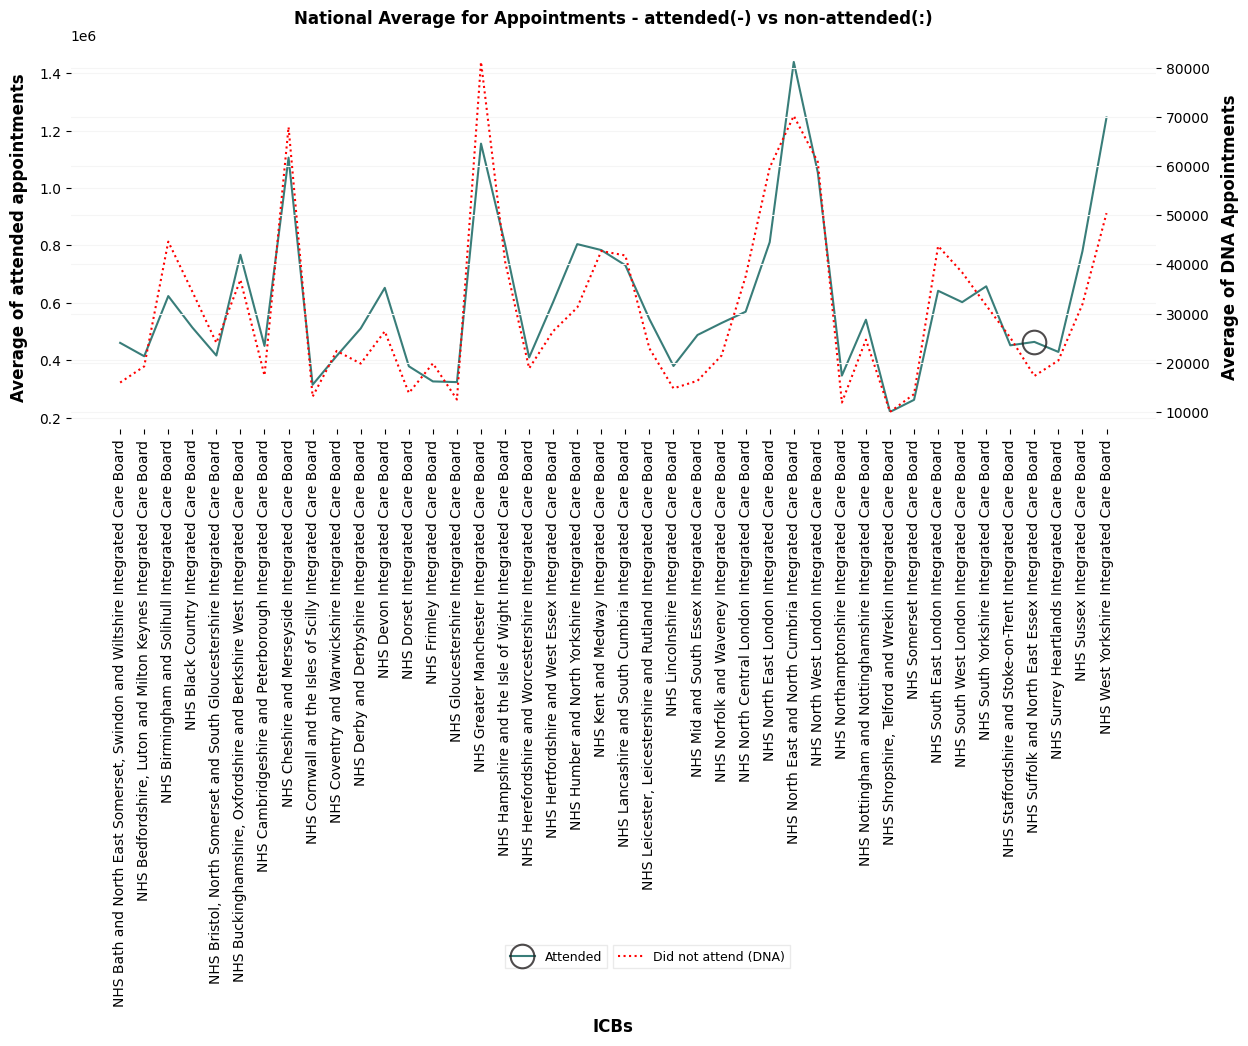

In [14]:
attended_df_mean2 = attended_df_mean.groupby('ICB_NAME').mean().reset_index()
dna_df_mean2 = dna_df_mean.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

# Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df_mean2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(0.6,30000), xytext=(36,60000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc =(0.4,-1.4))

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')
ax2.legend(loc =(0.5,-1.4))

plt.savefig(f'{plot_counter.plot_name}.png', dpi=300, bbox_inches='tight')

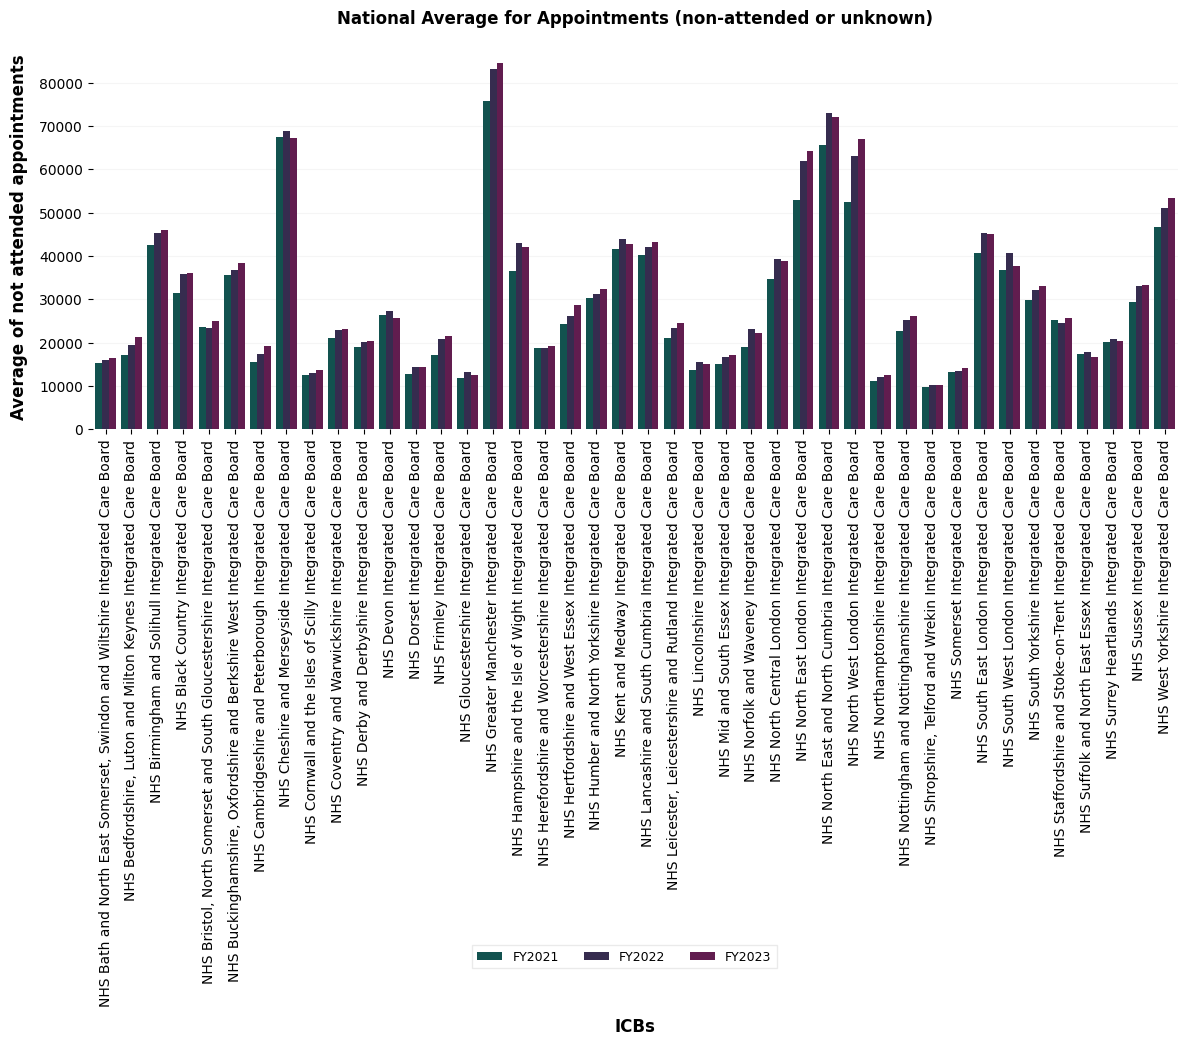

In [15]:
# Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.legend(loc=(0.35,-1.4), ncol=3)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [16]:
combined_df_copy

,ICB_NAME,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,COUNT_OF_APPOINTMENTS
0,NHS West Yorkshire Integrated Care Board,02T,2021-07,Attended,GP,Face-to-Face,1955
1,NHS West Yorkshire Integrated Care Board,02T,2021-07,Attended,GP,Face-to-Face,336
2,NHS West Yorkshire Integrated Care Board,02T,2021-07,Attended,GP,Face-to-Face,3794
3,NHS West Yorkshire Integrated Care Board,02T,2021-07,Attended,GP,Face-to-Face,152
4,NHS West Yorkshire Integrated Care Board,02T,2021-07,Attended,GP,Face-to-Face,1275
...,...,...,...,...,...,...,...
5866,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-12,Unknown,Unknown,Unknown,153
5867,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-12,Unknown,Unknown,Unknown,198
5868,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-12,Unknown,Unknown,Unknown,225
5869,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-12,Unknown,Unknown,Unknown,274


In [17]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face                3562285
                                                            Home Visit                    47789
                                                            Telephone                   2561123
                                                            Unknown                        3040
                                                            Video/Online                  36736
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                   7728
                                                            Home Visit                     3492
                                                            Telephone                     58760
                                                            Unknown                     1045819
                                                            Video/Online                    163

[602 rows x 1 columns]

In [18]:
# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face                  91540
                                                                        Home Visit                      404
                                                                        Telephone                      9916
                                                                        Unknown                         168
                                                                        Video/Online                    494
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                   6941
                                                   Unknown              Face-to-Face                      4
                                                                        Home Visit                       59
                                                                        Telephone                       681
                                                                        Unknown                       31986

[565 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [19]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,198079.8810,565451.9048,1379.9167
Home visit,1577.2857,2404.3333,1534.9444
Telephone,70122.6667,64354.0238,2402.3056
Unknown,2297.8537,4781.3810,12166.6452
Video/Online,1400.1667,3317.9524,6.2857


In [20]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face                  76471
                     Home Visit                      600
                     Telephone                     16085
                     Unknown                         230
                     Video/Online                   1071
Other Practice staff Face-to-Face                 359433
                     Home Visit                     1883
                     Telephone                     18308
                     Unknown                         546
                     Video/Online                   5310
Unknown              Face-to-Face                  27590
                     Home Visit                      163
                     Telephone                        73
                     Unknown                       13525

<Axes: >

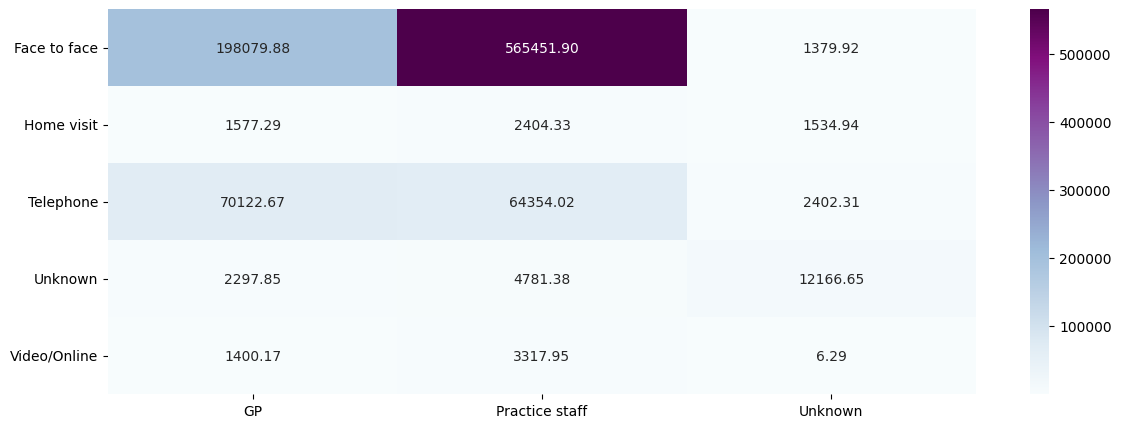

In [21]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

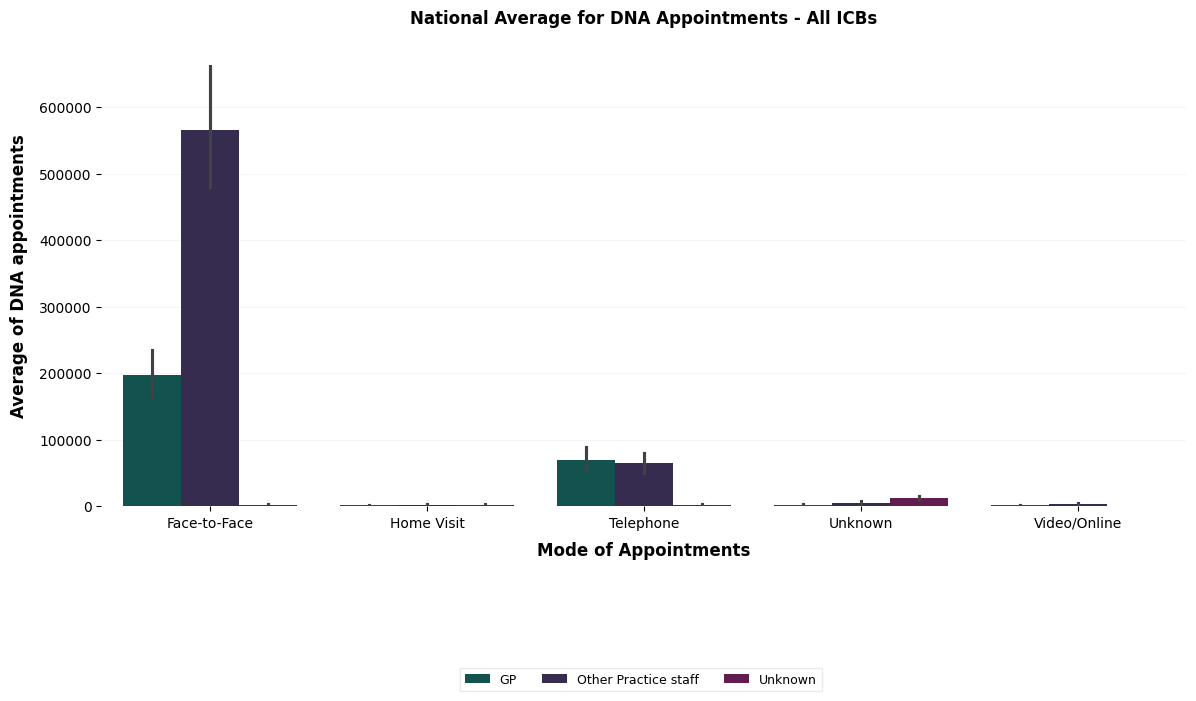

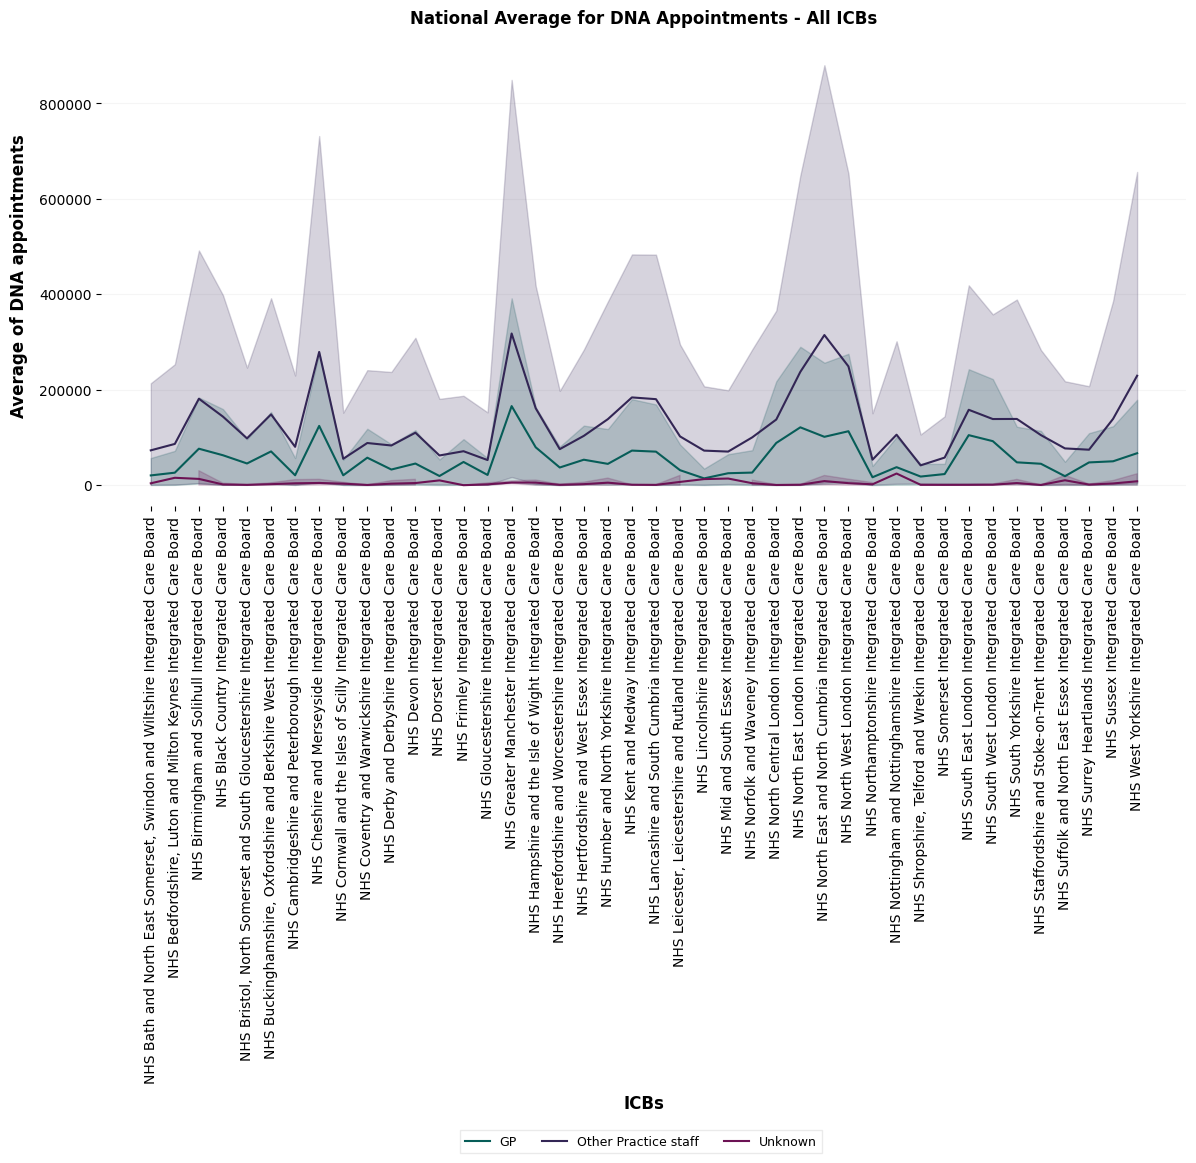

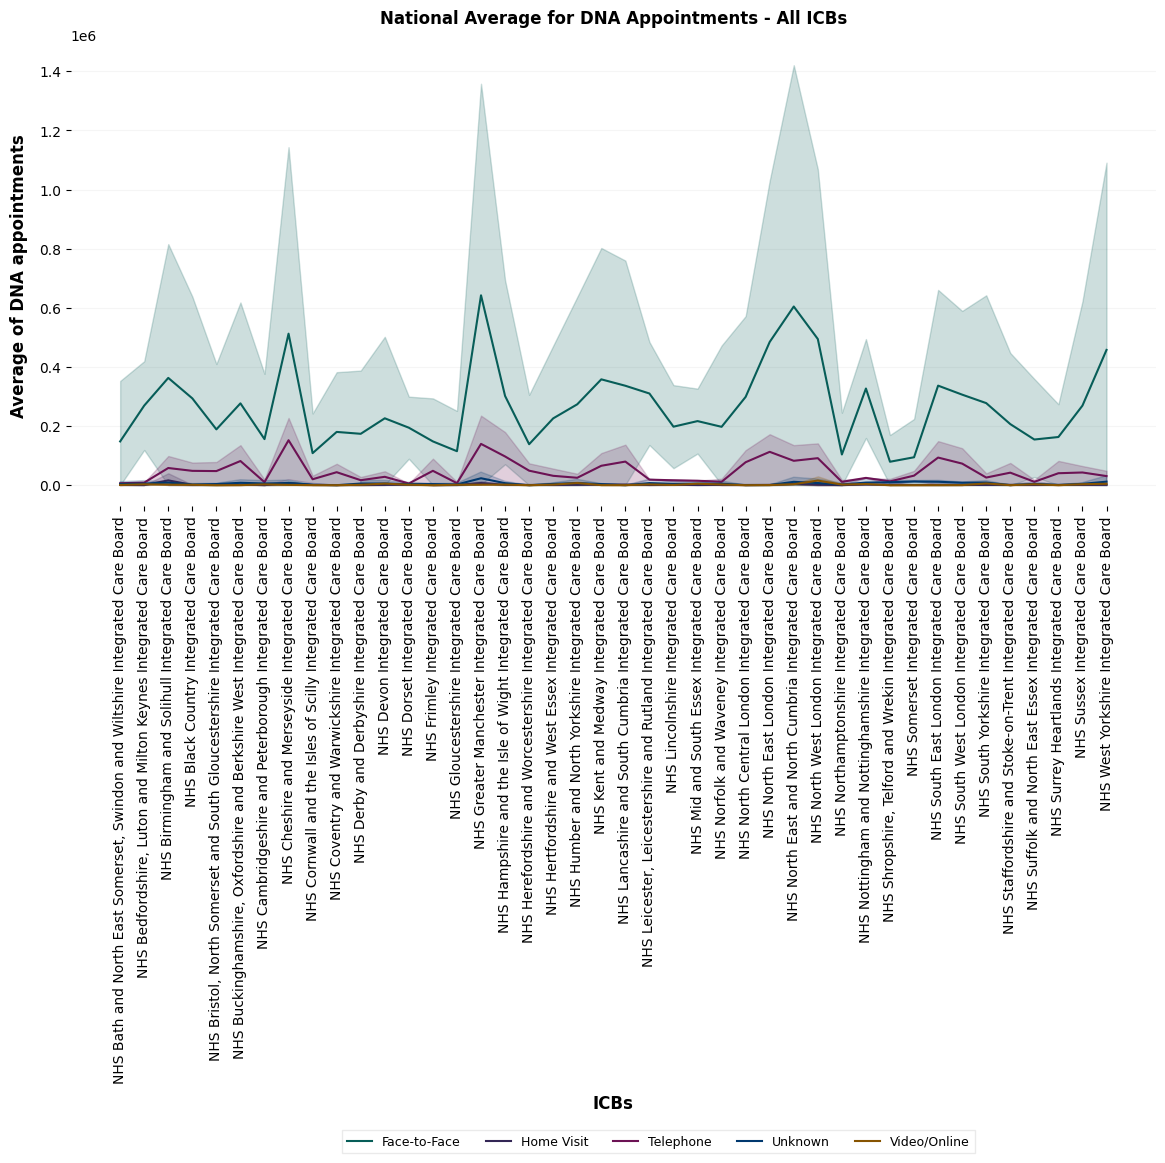

In [22]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-0.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-1.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.25,-1.4), ncol=5)

## **Analysis using proportion(%) of appointments**

### **Proportion based on FY-YEARS**

In [23]:
appt_proportion = combined_df_copy.loc[:,['SUB_ICB_LOCATION_CODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion.sum(axis=1)
appt_proportion = appt_proportion.div(sum_row, axis=0)*100
appt_proportion = appt_proportion.reset_index()
appt_proportion.columns = ['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']
appt_proportion.head()

,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,Attended,DNA,Unknown
0,00L,2021-07,94.473248,2.890877,2.635876
1,00L,2021-08,94.899467,2.905211,2.195322
2,00L,2021-09,91.772276,3.735786,4.491938
3,00L,2021-10,91.518022,4.267304,4.214673
4,00L,2021-11,93.542097,3.352270,3.105633


In [24]:
# Converting months into FY-years
appt_proportion['FY_YEAR'] = appt_proportion['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
appt_proportion_fy = appt_proportion.drop(columns=['APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','FY_YEAR']).mean().round(2)
appt_proportion_fy.head()

Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
00L                   FY2021      93.61  3.37     3.02
                      FY2022      93.08  3.69     3.23
                      FY2023      90.98  3.76     5.26
00N                   FY2021      91.55  4.27     4.18
                      FY2022      90.39  4.37     5.24

In [25]:
snee_sub_icb = ['06L','06T','07K']

National_proportion_2021 = appt_proportion_fy.loc[slice(None),'FY2021',:].mean().round(2)
National_proportion_2022 = appt_proportion_fy.loc[slice(None),'FY2022',:].mean().round(2)
National_proportion_2023_april_august = appt_proportion_fy.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_sub_icb_proportion = appt_proportion_fy.loc[snee_sub_icb,:]


print(f'{National_proportion_2021} is the National PROPORTION for appointments(FY-2021)')
print(f'{National_proportion_2022} is the National PROPORTION for appointments(FY-2022)')
print(f'{National_proportion_2023_april_august} is the National PROPORTION for appointments(FY-2023, april-august)')

SNEE_sub_icb_proportion

Attended    91.28
DNA          4.42
Unknown      4.30
dtype: float64 is the National PROPORTION for appointments(FY-2021)
Attended    91.21
DNA          4.63
Unknown      4.17
dtype: float64 is the National PROPORTION for appointments(FY-2022)
Attended    89.96
DNA          4.56
Unknown      5.48
dtype: float64 is the National PROPORTION for appointments(FY-2023, april-august)


Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
06L                   FY2021      94.03  2.58     3.40
                      FY2022      93.62  2.79     3.59
                      FY2023      91.27  2.91     5.82
06T                   FY2021      91.08  5.13     3.79
                      FY2022      91.16  4.91     3.92
                      FY2023      90.61  3.94     5.44
07K                   FY2021      94.97  2.78     2.25
                      FY2022      94.88  2.84     2.29
                      FY2023      93.25  2.78     3.97

In [26]:
SNEE_proportion = SNEE_sub_icb_proportion.reset_index().drop(columns=['SUB_ICB_LOCATION_CODE']).groupby(['FY_YEAR']).mean().round(2)
SNEE_proportion

,Attended,DNA,Unknown
FY_YEAR,,,
FY2021,93.36,3.50,3.15
FY2022,93.22,3.51,3.27
FY2023,91.71,3.21,5.08


### **Proportion based on HCP_TYPE and APPT_MODE**

In [27]:
appt_proportion_df = combined_df_copy.loc[:,['ICB_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS']].pivot_table(index=['ICB_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df_imputed = appt_proportion_df.fillna(appt_proportion_df.mean())
appt_proportion_df_imputed.head()

COUNT_OF_APPOINTMENTS  \
APPT_STATUS                                                                           Attended   
ICB_NAME                                           HCP_TYPE APPT_MODE                            
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             94.540472   
                                                            Home Visit               95.608595   
                                                            Telephone                98.025462   
                                                            Unknown                  45.285267   
                                                            Video/Online             95.771417   

                                                                                    \
APPT_STATUS                                                                    DNA   
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face  2.429406   
                                                            Home Visit    0.808259   
                                                            Telephone     0.379529   
                                                            Unknown       2.502607   
                                                            Video/Online  1.287867   

                                                                                     
APPT_STATUS                                                                 Unknown  
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face   3.030122  
                                                            Home Visit     3.583147  
                                                            Telephone      1.595009  
                                                            Unknown       52.212126  
                                                            Video/Online   2.940716

In [28]:
# Calculating National average for HCP='GP' for Appointments
GP_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(2)
GP_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Home Visit'),:].mean().round(2)
GP_tel_ratio = appt_proportion_df_imputed.loc[:,'GP','Telephone'].mean().round(2)
GP_unknown_ratio = appt_proportion_df_imputed.loc[:,'GP','Unknown'].mean().round(2)
GP_video_online_ratio = appt_proportion_df_imputed.loc[:,'GP','Video/Online'].mean().round(2)

# Calculating National average for HCP='Other practice staff' for  Appointments
other_staff_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(2)
other_staff_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(2)
other_staff_tel_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Telephone'].mean().round(2)
other_staff_unknown_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Unknown'].mean().round(2)
other_staff_video_online_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Video/Online'].mean().round(2)

# Calculating National ratio for HCP='unknown' for Appointments
unknown_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(2)
unknown_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(2)
unknown_tel_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Telephone'].mean().round(2)
unknown_unknown_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Unknown'].mean().round(2)
unknown_video_online_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Video/Online'].mean().round(2)

In [29]:
res = {
    ('GP','Attended') : [GP_f2f_ratio.iloc[0], GP_homevisit_ratio.iloc[0], GP_tel_ratio.iloc[0], GP_unknown_ratio.iloc[0], GP_video_online_ratio.iloc[0]],
    ('GP','DNA') : [GP_f2f_ratio.iloc[1], GP_homevisit_ratio.iloc[1], GP_tel_ratio.iloc[1], GP_unknown_ratio.iloc[1], GP_video_online_ratio.iloc[1]],
    ('GP','Unknown') : [GP_f2f_ratio.iloc[2], GP_homevisit_ratio.iloc[2], GP_tel_ratio.iloc[2], GP_unknown_ratio.iloc[2], GP_video_online_ratio.iloc[2]],
    ('Other Staff','Attended') : [other_staff_f2f_ratio.iloc[0], other_staff_homevisit_ratio.iloc[0], other_staff_tel_ratio.iloc[0], other_staff_unknown_ratio.iloc[0], other_staff_video_online_ratio.iloc[0]],
    ('Other Staff','DNA') : [other_staff_f2f_ratio.iloc[1], other_staff_homevisit_ratio.iloc[1], other_staff_tel_ratio.iloc[1], other_staff_unknown_ratio.iloc[1], other_staff_video_online_ratio.iloc[1]],
    ('Other Staff','Unknown') : [other_staff_f2f_ratio.iloc[2], other_staff_homevisit_ratio.iloc[2], other_staff_tel_ratio.iloc[2], other_staff_unknown_ratio.iloc[2], other_staff_video_online_ratio.iloc[2]],
    ('Unknown','Attended') : [unknown_f2f_ratio.iloc[0], unknown_homevisit_ratio.iloc[0], unknown_tel_ratio.iloc[0], unknown_unknown_ratio.iloc[0], unknown_video_online_ratio.iloc[0]],
    ('Unknown','DNA') : [unknown_f2f_ratio.iloc[1], unknown_homevisit_ratio.iloc[1], unknown_tel_ratio.iloc[1], unknown_unknown_ratio.iloc[1], unknown_video_online_ratio.iloc[1]],
    ('Unknown','Unknown') : [unknown_f2f_ratio.iloc[2], unknown_homevisit_ratio.iloc[2], unknown_tel_ratio.iloc[2], unknown_unknown_ratio.iloc[2], unknown_video_online_ratio.iloc[2]]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_ratio_dna_hcp_appt_type = pd.DataFrame(res, index=index_values)
national_ratio_dna_hcp_appt_type

GP               Other Staff                Unknown        \
             Attended   DNA Unknown    Attended   DNA Unknown Attended   DNA   
Face to face    93.10  3.56    3.34       87.37  7.32    5.31    76.20  2.70   
Home visit      83.61  2.20   14.20       81.45  3.31   15.24    67.05  4.03   
Telephone       95.77  1.56    2.67       92.58  3.21    4.21    89.73  2.50   
Unknown         60.49  2.72   36.87       50.32  3.85   45.83    76.94  2.68   
Video/Online    90.46  1.09    8.45       87.66  2.65    9.69    81.68  3.77   

                      
             Unknown  
Face to face   23.41  
Home visit     31.19  
Telephone      10.54  
Unknown        30.84  
Video/Online   19.11

In [30]:
appt_proportion_df_imputed.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:].round(2)

COUNT_OF_APPOINTMENTS               
APPT_STATUS                                    Attended    DNA Unknown
HCP_TYPE             APPT_MODE                                        
GP                   Face-to-Face                 95.02   2.28    2.70
                     Home Visit                   93.81   1.63    4.55
                     Telephone                    97.67   0.67    1.66
                     Unknown                      60.07   2.58   37.36
                     Video/Online                 91.55   1.73    6.72
Other Practice staff Face-to-Face                 89.76   5.25    4.99
                     Home Visit                   88.55   3.59    7.86
                     Telephone                    95.63   1.20    3.17
                     Unknown                      39.85   2.98   57.17
                     Video/Online                 90.70   5.64    3.66
Unknown              Face-to-Face                 26.69  64.14    9.16
                     Home Visit                   88.06   0.92   11.02
                     Telephone                    91.27   3.25    5.48
                     Unknown                      91.42   2.35    6.22
                     Video/Online                100.00   3.13   17.26

## **Plots** 

In [31]:
appt_proportion_df_plots = combined_df_copy.pivot_table(index=['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df_plots.sum(axis=1)
appt_proportion_df_plots = appt_proportion_df_plots.div(sum_row, axis=0)*100
appt_proportion_df_plots = appt_proportion_df_plots.reset_index().round(2)
appt_proportion_df_plots.columns = ['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']

# Converting months into FY-years
appt_proportion_df_plots['FY_YEAR'] = appt_proportion_df_plots['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")
appt_proportion_df_plots

,ICB_NAME,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,APPOINTMENT_MONTH,Attended,DNA,Unknown,FY_YEAR
0,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-07,96.52,1.77,1.71,FY2021
1,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-08,96.52,1.84,1.64,FY2021
2,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-09,94.92,2.31,2.77,FY2021
3,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-10,90.55,3.20,6.25,FY2021
4,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-11,94.42,2.58,3.00,FY2021
...,...,...,...,...,...,...,...,...,...
37326,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-08,88.71,2.42,8.87,FY2023
37327,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-09,84.58,2.26,13.16,FY2023
37328,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-10,88.09,2.91,9.01,FY2023
37329,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-11,88.25,2.78,8.97,FY2023


### **Attended Appointments** 

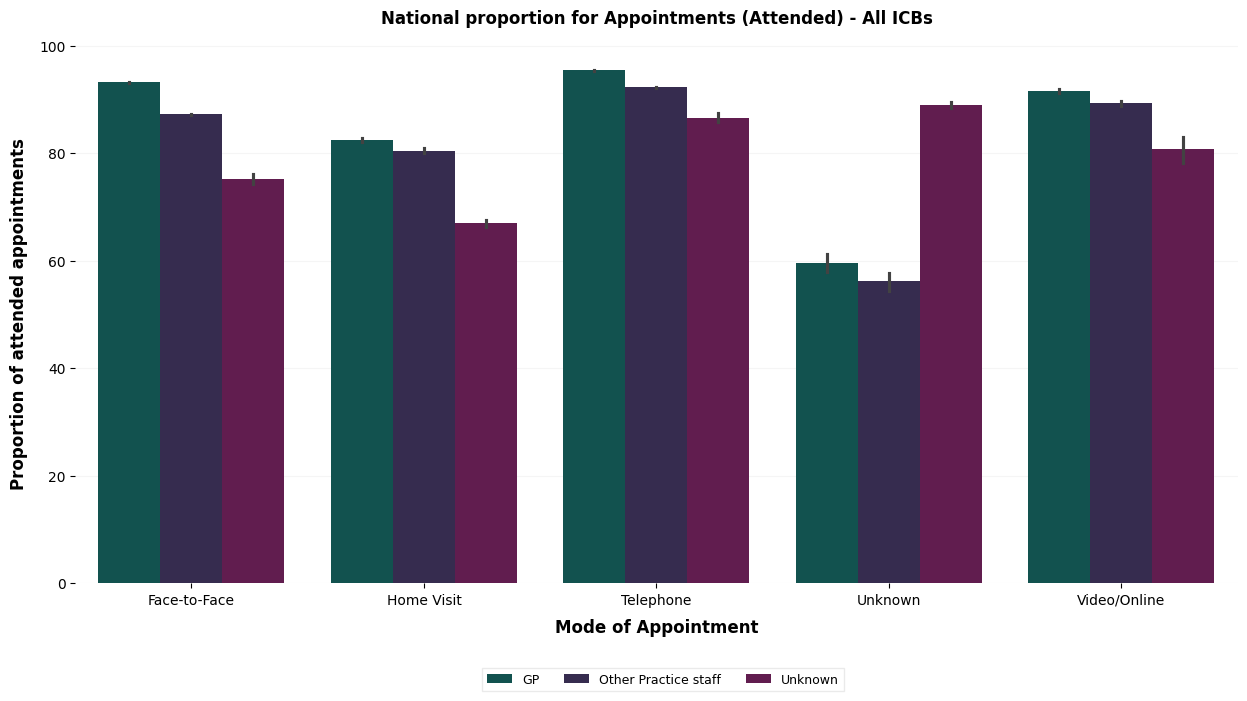

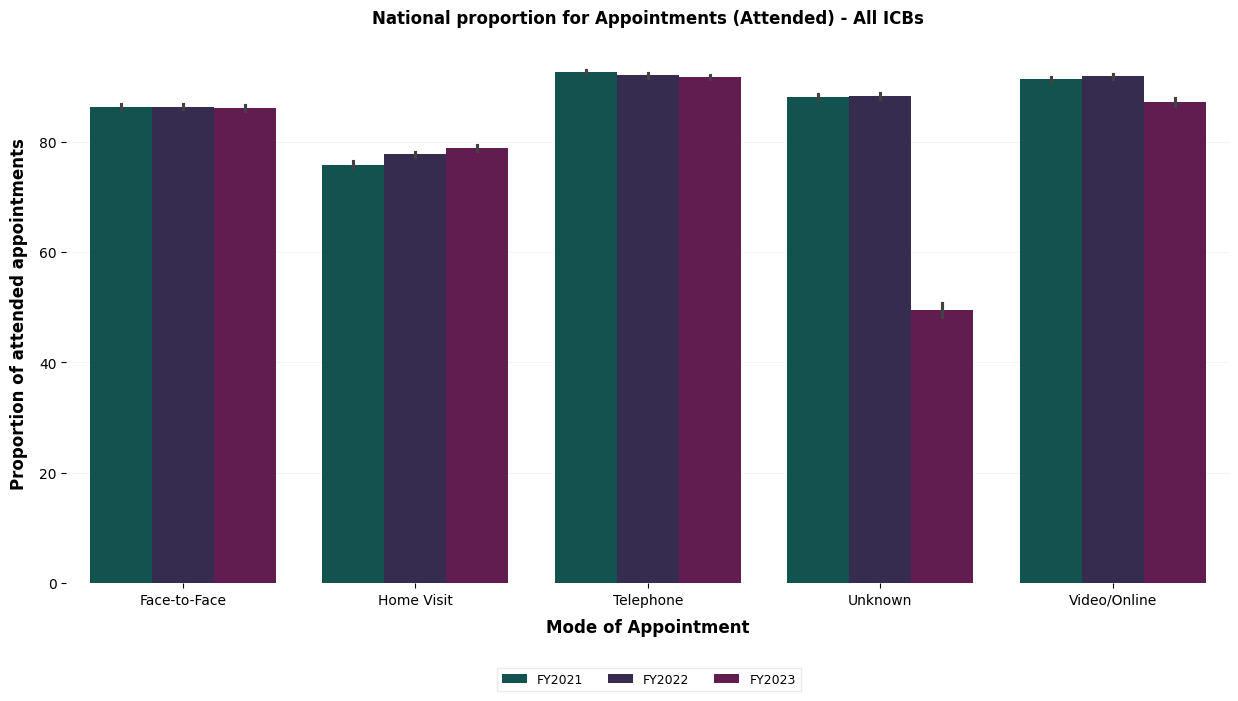

In [32]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.35,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

### **DNA Appointments** 

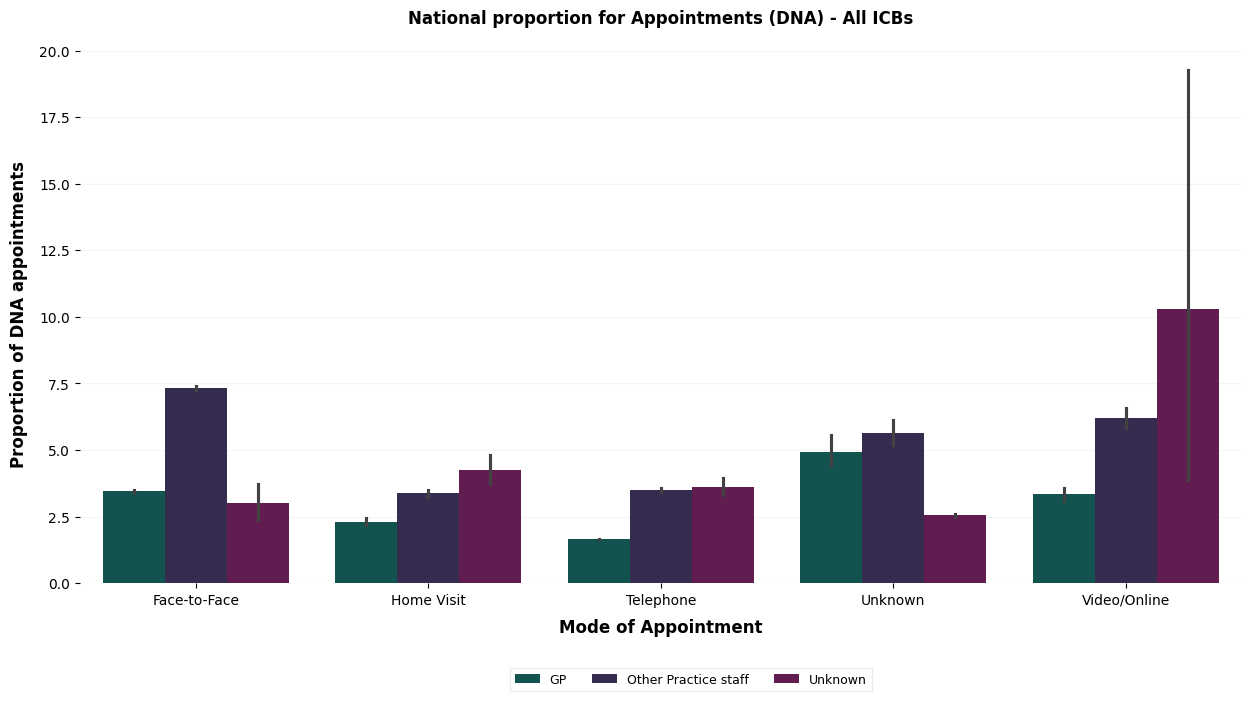

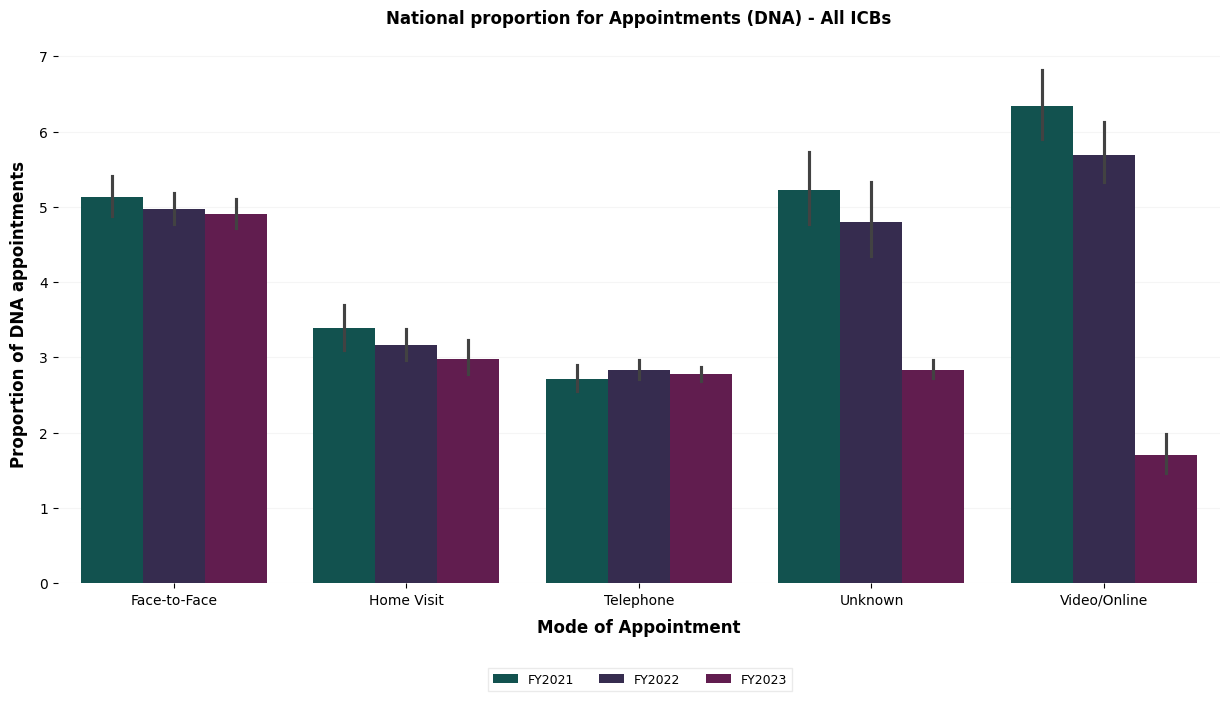

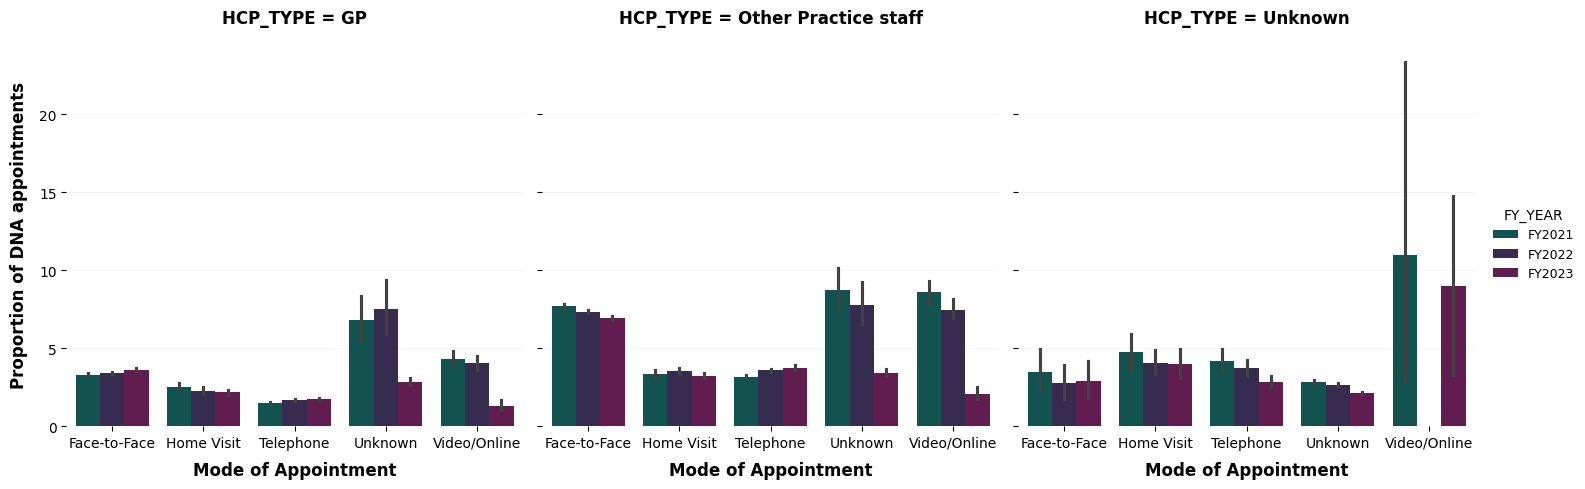

In [33]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df_plots)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

### **Correlation matrix all sub-icb's**

In [34]:
# Select categorical columns
categorical_columns = ['ICB_NAME','HCP_TYPE', 'APPT_MODE']

# Convert categorical columns to one-hot encoded features
one_hot_encoded = pd.get_dummies(appt_proportion_df_plots[categorical_columns])

dna_correlations_all_sub_icbs = one_hot_encoded.corrwith(appt_proportion_df_plots['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.172416
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.132351
APPT_MODE_Face-to-Face                                                                    0.113609
APPT_MODE_Video/Online                                                                    0.057964
ICB_NAME_NHS Black Country Integrated Care Board                                          0.041223
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.040896
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.034067
APPT_MODE_Unknown                                                                         0.016550
ICB_NAME_NHS South East London Integrated Care Board                                      0.016329
ICB_NAME_NHS Cheshire and Merseyside Integrated Care Board                                0.015539
ICB_NAME_N

### **SNEE sub-icb Analysis**

In [35]:
snee_appt_proportion_df = appt_proportion_df_plots.loc[appt_proportion_df_plots['SUB_ICB_LOCATION_CODE'].isin(snee_sub_icb)]
snee_appt_proportion_df = snee_appt_proportion_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()
snee_appt_proportion_df

Attended       DNA  \
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR                         
06L                   GP       Face-to-Face FY2021    95.816667  1.434444   
                                            FY2022    95.175000  1.620833   
                                            FY2023    93.836667  1.672222   
                               Home Visit   FY2021    95.192222  2.571111   
                                            FY2022    94.628333  2.084167   
...                                                         ...       ...   
07K                   Unknown  Telephone    FY2022   100.000000       NaN   
                                            FY2023    83.335000       NaN   
                               Unknown      FY2021    95.992222  1.413333   
                                            FY2022    94.431667  1.933333   
                                            FY2023    92.428889  1.531111   

                                                       Unknown  
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR             
06L                   GP       Face-to-Face FY2021    2.750000  
                                            FY2022    3.205000  
                                            FY2023    4.492222  
                               Home Visit   FY2021    2.236667  
                                            FY2022    3.288333  
...                                                        ...  
07K                   Unknown  Telephone    FY2022         NaN  
                                            FY2023   66.665000  
                               Unknown      FY2021    2.595556  
                                            FY2022    3.632500  
                                            FY2023    6.038889  

[110 rows x 3 columns]

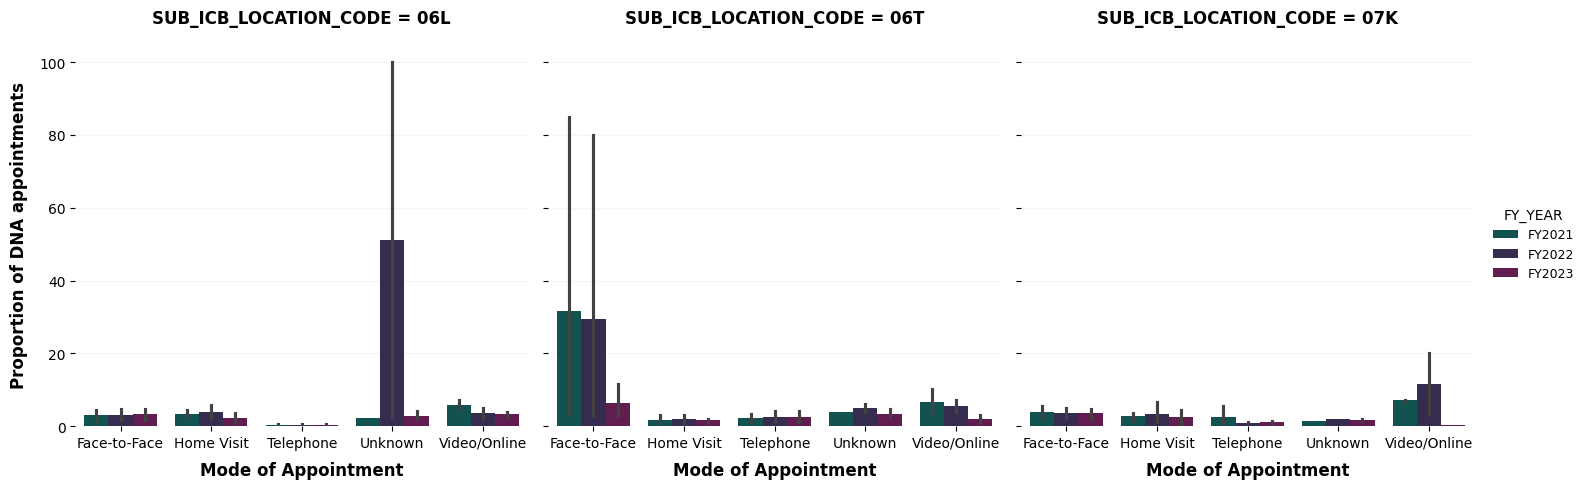

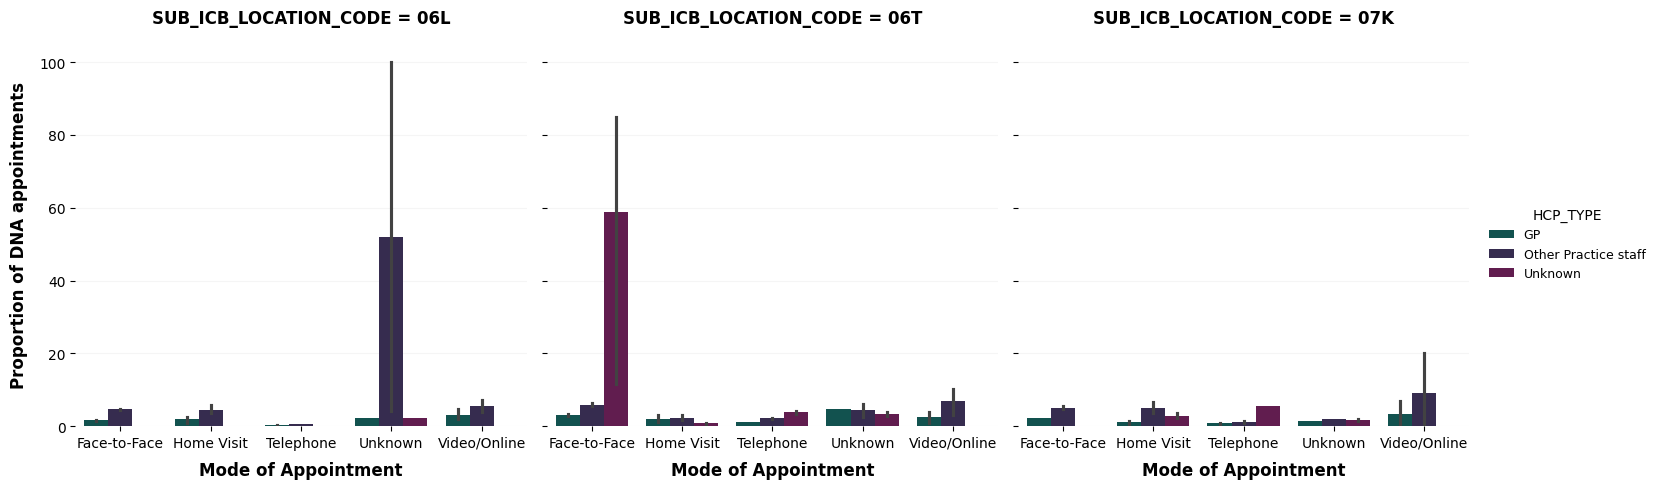

In [36]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

In [37]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

### **Correlation matrix SNEE sub-icb's**

In [38]:
snee_appt_proportion_df

,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,06L,GP,Face-to-Face,FY2021,95.816667,1.434444,2.750000
1,06L,GP,Face-to-Face,FY2022,95.175000,1.620833,3.205000
2,06L,GP,Face-to-Face,FY2023,93.836667,1.672222,4.492222
3,06L,GP,Home Visit,FY2021,95.192222,2.571111,2.236667
4,06L,GP,Home Visit,FY2022,94.628333,2.084167,3.288333
...,...,...,...,...,...,...,...
105,07K,Unknown,Telephone,FY2022,100.000000,NaN,NaN
106,07K,Unknown,Telephone,FY2023,83.335000,NaN,66.665000
107,07K,Unknown,Unknown,FY2021,95.992222,1.413333,2.595556
108,07K,Unknown,Unknown,FY2022,94.431667,1.933333,3.632500


In [39]:
cols = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']

# Convert categorical columns to one-hot encoded features
ce_OHE = pd.get_dummies(snee_appt_proportion_df[cols])

dna_correlations_snee_icbs = ce_OHE.corrwith(snee_appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.205847
HCP_TYPE_Unknown                 0.164714
SUB_ICB_LOCATION_CODE_06T        0.098137
APPT_MODE_Unknown                0.087837
HCP_TYPE_Other Practice staff    0.055561
SUB_ICB_LOCATION_CODE_06L        0.013453
APPT_MODE_Video/Online          -0.017480
SUB_ICB_LOCATION_CODE_07K       -0.115044
APPT_MODE_Home Visit            -0.117593
APPT_MODE_Telephone             -0.144478
HCP_TYPE_GP                     -0.195463
dtype: float64


## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [40]:
print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

28924.54 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
32014.04 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,17453.4
FY2022,17822.6
FY2023,16704.0


- We can see that the each year's average for non-attended appointments for SNEE-ICB is much lesser than National Average.
  
- For year 2022, this difference increases as the National average is 31,568.7, whereas for SNEE-ICB it is 17,822.6

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

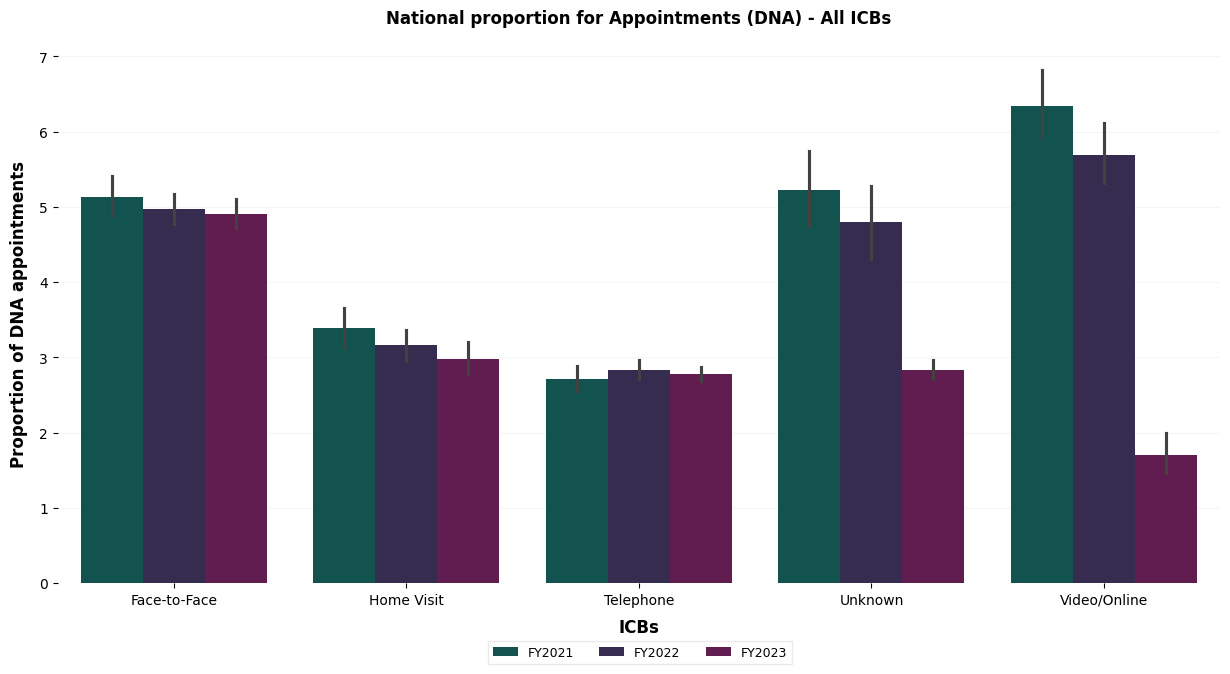

In [41]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.15), ncol=3)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

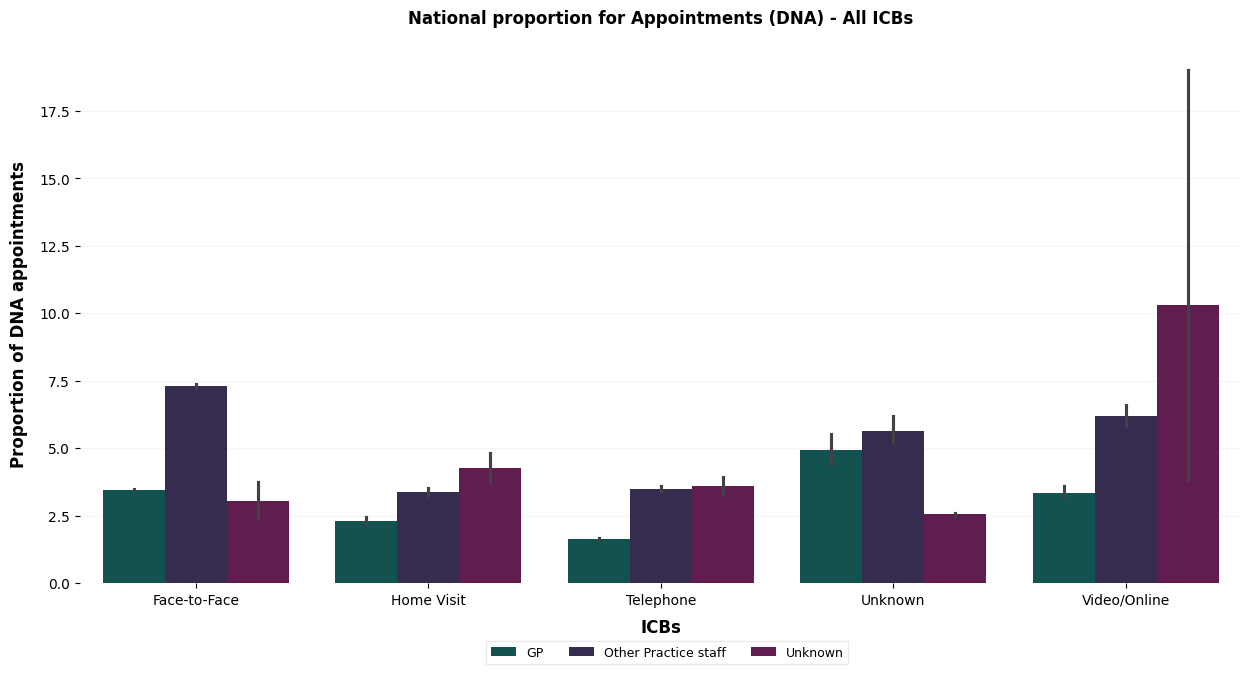

In [42]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.35,-0.15), ncol=3)
plt.show()

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
5. to determine if a patient with the above appointment will attend.

#### 1. **For Snee ICB'S**

In [43]:
print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.205847
HCP_TYPE_Unknown                 0.164714
SUB_ICB_LOCATION_CODE_06T        0.098137
APPT_MODE_Unknown                0.087837
HCP_TYPE_Other Practice staff    0.055561
SUB_ICB_LOCATION_CODE_06L        0.013453
APPT_MODE_Video/Online          -0.017480
SUB_ICB_LOCATION_CODE_07K       -0.115044
APPT_MODE_Home Visit            -0.117593
APPT_MODE_Telephone             -0.144478
HCP_TYPE_GP                     -0.195463
dtype: float64


- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment_MODE = 'Face-to-face' and HCP_TYPE = 'Unknown', then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP_TYPE = 'GP', then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### 2. **For all sub-icbs(102)**

In [44]:
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.172416
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.132351
APPT_MODE_Face-to-Face                                                                    0.113609
APPT_MODE_Video/Online                                                                    0.057964
ICB_NAME_NHS Black Country Integrated Care Board                                          0.041223
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.040896
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.034067
APPT_MODE_Unknown                                                                         0.016550
ICB_NAME_NHS South East London Integrated Care Board                                      0.016329
ICB_NAME_NHS Cheshire and Merseyside Integrated Care Board                                0.015539
ICB_NAME_N

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 6. Persist the distribution information from 5. to a yaml file.

In [45]:
years_to_keep = ['FY2022', 'FY2023']

filtered_df = appt_proportion_df_plots[appt_proportion_df_plots['FY_YEAR'].isin(years_to_keep)]

filtered_df = filtered_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH','FY_YEAR','Unknown','Attended']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).mean().round(2)
filtered_df = filtered_df.fillna(filtered_df.mean()).div(100).round(4)
filtered_df

DNA
SUB_ICB_LOCATION_CODE HCP_TYPE             APPT_MODE           
00L                   GP                   Face-to-Face  0.0225
                                           Home Visit    0.0195
                                           Telephone     0.0084
                                           Unknown       0.0246
                                           Video/Online  0.0252
...                                                         ...
X2C4Y                 Other Practice staff Telephone     0.0100
                                           Unknown       0.0418
                                           Video/Online  0.0459
                      Unknown              Face-to-Face  0.0376
                                           Unknown       0.0270

[1466 rows x 1 columns]

In [46]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [47]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[sub_icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[sub_icb_code]:
        nested_dna_proportion_dict[sub_icb_code][hcp_type] = {}
    nested_dna_proportion_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_dna_proportion_dict

{'00L': {'GP': {'Face-to-Face': 0.0225,
   'Home Visit': 0.0195,
   'Telephone': 0.0084,
   'Unknown': 0.0246,
   'Video/Online': 0.0252},
  'Other Practice staff': {'Face-to-Face': 0.0644,
   'Home Visit': 0.0097,
   'Telephone': 0.0232,
   'Unknown': 0.0249,
   'Video/Online': 0.0562},
  'Unknown': {'Face-to-Face': 0.0059,
   'Home Visit': 0.0062,
   'Telephone': 0.1429,
   'Unknown': 0.0255}},
 '00N': {'GP': {'Face-to-Face': 0.0321,
   'Home Visit': 0.0664,
   'Telephone': 0.022,
   'Unknown': 0.0376,
   'Video/Online': 0.0323},
  'Other Practice staff': {'Face-to-Face': 0.0649,
   'Home Visit': 0.0278,
   'Telephone': 0.0488,
   'Unknown': 0.0376,
   'Video/Online': 0.0028},
  'Unknown': {'Face-to-Face': 0.0012,
   'Home Visit': 0.0182,
   'Telephone': 0.0291}},
 '00P': {'GP': {'Face-to-Face': 0.0431,
   'Home Visit': 0.0159,
   'Telephone': 0.0201,
   'Unknown': 0.013,
   'Video/Online': 0.0005},
  'Other Practice staff': {'Face-to-Face': 0.0761,
   'Home Visit': 0.0166,
   'Telep

In [48]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(dna_proportion_dict, yaml_file)